# Imports

In [1]:
from community_utils_3layers import *
from Ternary_contour_plot.Plotly_ternary_contour_plot import *

D:\Programs\Anaconda\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
import leidenalg
import igraph as ig

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# Construct the graph

1 Tube (All underground lines aggregated) \
2 Overground \
3 DLR

In [4]:
'''Construct edge lists'''
graph_names = ['Tube', 'Overground', 'DLR']
graph_order = {'1': 'Tube', '2': 'Overground', '3': 'DLR'}
edge_list_layers = {key: [] for key in graph_names}
file = open('data/london_transport_multiplex.txt')
for line in file:
    spl_line = line.split()
    if spl_line:
        edge_list_layers[graph_order[spl_line[0]]].append((spl_line[1], spl_line[2], int(spl_line[3])))
file.close()


'''Define all existing nodes'''
node_list = []
for layer_name in graph_names:
    for item in edge_list_layers[layer_name]:
        if item[0] not in node_list:
            node_list.append(item[0])
        if item[1] not in node_list:
            node_list.append(item[1])
whole_nodes = {name: ID for ID, name in enumerate(set(node_list))}


'''Form adjacency matrix'''
adj_matricies = {layer_name: np.zeros(shape=(len(node_list), len(node_list))) for layer_name in edge_list_layers.keys()}
for layer_name in graph_names:
    for edge in edge_list_layers[layer_name]:
        adj_matricies[layer_name][whole_nodes[edge[0]], whole_nodes[edge[1]]] = edge[2]
        adj_matricies[layer_name][whole_nodes[edge[1]], whole_nodes[edge[0]]] = edge[2]


'''Construct the graph'''
# graph_layers_ig = {layer_name: ig.Graph.Adjacency(adj_matricies[layer_name]) for layer_name in graph_names}
graph_layers_nx = {layer_name: nx.from_numpy_matrix(adj_matricies[layer_name]) for layer_name in graph_names}

# Set weights and normalize

Networkx

In [14]:
for name in graph_names:
    graph_layers_nx[name] = normalize_to_fixed_weight_nx(graph_layers_nx[name], 1, show=True)

The whole weight has been equalt to 374.0 . Now it is equal to 1.000000000000003
The whole weight has been equalt to 83.0 . Now it is equal to 1.0000000000000013
The whole weight has been equalt to 46.0 . Now it is equal to 0.9999999999999994


In [15]:
node_list = take_first(graph_layers_nx.values()).nodes()

# Define the best partitions for all the methods

Set the grid

In [16]:
step_number = 21
alpha = np.linspace(0, 1, step_number)
alphas_grid = []
for number, a1 in enumerate(alpha):
    alpha23 = np.linspace(0, 1-a1, step_number-number)
    for a2 in alpha23:
        a3 = 1 - a1 - a2
        alphas_grid.append((a1, a2, a3))

In [17]:
alpha_order = {key: val for val, key in enumerate(graph_names)}
alpha_order

{'Tube': 0, 'Overground': 1, 'DLR': 2}

Set the number of simulations

In [19]:
simulations_number = 10

Run to detect the best partitions for all graph configurations according to alpha grid with the fixed number of simulations per each configuration.

In [22]:
sf_partit = SF_leiden(graph_layers_nx, simulations_number, alphas_grid, alpha_order)
ef_partit = EF_leiden(graph_layers_nx, simulations_number, alphas_grid, alpha_order)
lf_partit, partition_phase1 = LF_leiden(graph_layers_nx, simulations_number, alphas_grid, alpha_order)

Run this too if you have just defined the best partitions

In [23]:
partition = {'sf': sf_partit, 'ef': ef_partit, 'lf': lf_partit}

Save the data

In [24]:
save('data/partitions/london_sf_partit.txt', sf_partit)
save('data/partitions/london_ef_partit.txt', ef_partit)
save('data/partitions/london_lf_partit.txt', lf_partit)

Or read the data if you have already defined the best partitions

In [ ]:
partition = {name: read_raw_file(file_name) for name, file_name 
             in zip(graph_names, ['data/partitions/london_sf_partit.txt', 
                                  'data/partitions/london_ef_partit.txt',
                                  'data/partitions/london_lf_partit.txt'])}

# Composite modularity of the methods in terms of different objective functions

In [25]:
Q_sf = {method: compute_experiment('sf', partition[method], graph_layers_nx, node_list, alpha_order)
        for method in ['sf', 'ef', 'lf']}

Q_ef = {method: compute_experiment('ef', partition[method], graph_layers_nx, node_list, alpha_order)
        for method in ['sf', 'ef', 'lf']}

short_graph_layers_lf = {item[0]: late_fusion_transient_absorption(item[1], partition_phase1[item[0]]) 
                             for item in graph_layers_nx.items()}
Q_lf = {method: compute_experiment('lf', partition[method], short_graph_layers_lf, node_list, alpha_order)
        for method in ['sf', 'ef', 'lf']}

### Take just the median in order to plot a surface

In [26]:
import statistics

def median(data, simulations_number):
    length = len(data[0])
    ongoing = 0
    new_alphas, new_modularities = [], []
    while ongoing != length:
        new_alphas.append(data[0][ongoing])
        new_modularities.append(statistics.median(data[1][ongoing:ongoing+simulations_number]))
        ongoing += simulations_number
    return [new_alphas, new_modularities]

def extract_median(data, simulations_number):
    new_data = {key: None for key in data.keys()}
    for name, content in data.items():
        new_data[name] = median(content, simulations_number)
    return new_data

##### PLOT

<IPython.core.display.Javascript object>


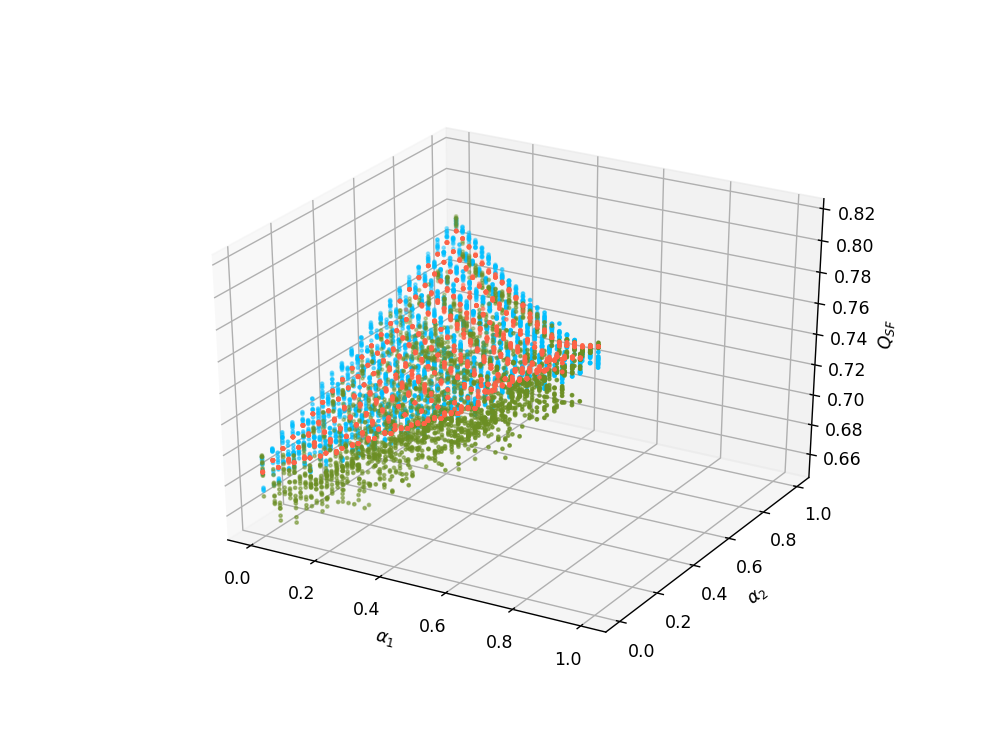

In [31]:
plot_dots(Q_sf, r'$Q_{SF}$', 'data/plots/london_sf.pdf')

<IPython.core.display.Javascript object>


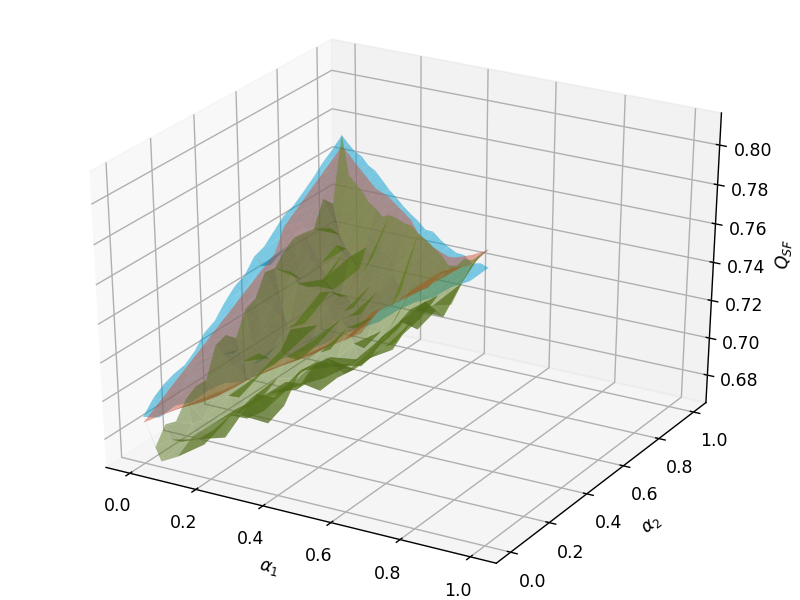

In [32]:
plot_surface(extract_median(Q_sf, simulations_number), r'$Q_{SF}$', 'data/plots/london_surf_sf.pdf')

<IPython.core.display.Javascript object>


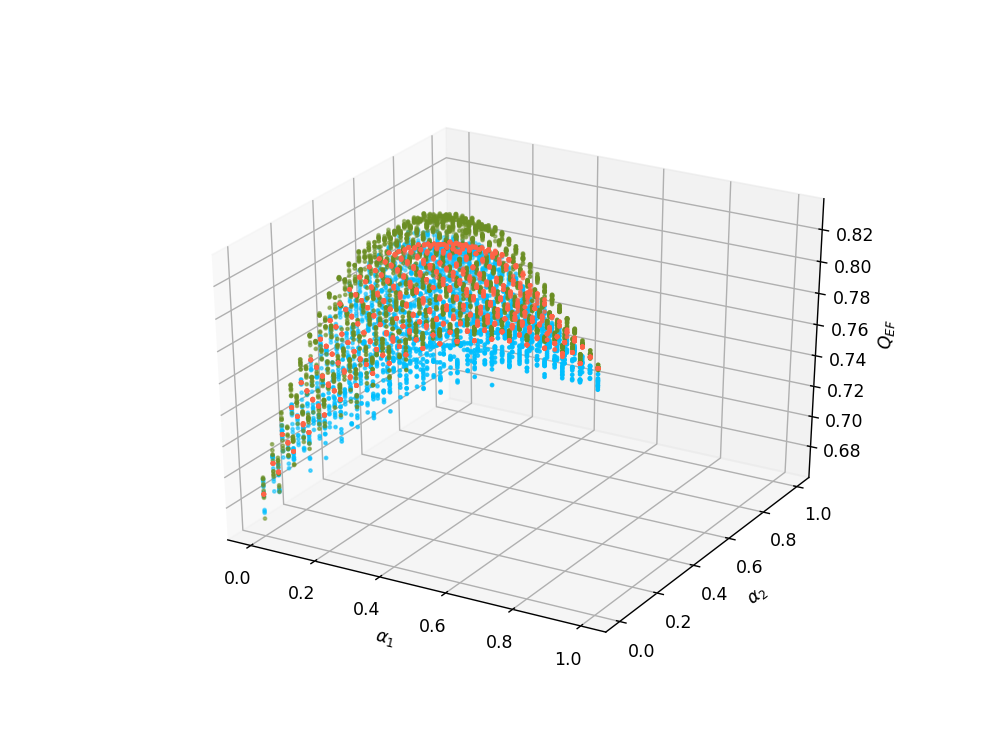

In [33]:
plot_dots(Q_ef, r'$Q_{EF}$', 'data/plots/london_ef.pdf')

<IPython.core.display.Javascript object>


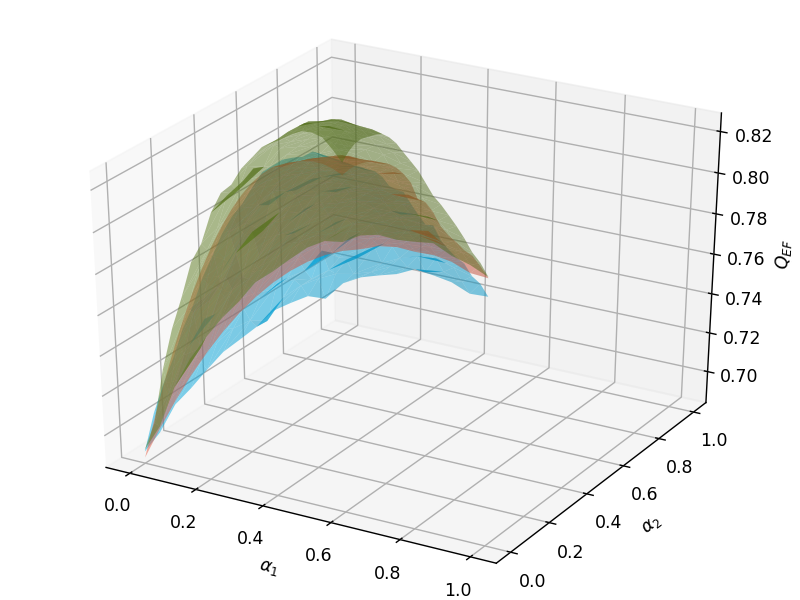

In [34]:
plot_surface(extract_median(Q_ef, simulations_number), r'$Q_{EF}$', 'data/plots/london_surf_ef.pdf')

<IPython.core.display.Javascript object>


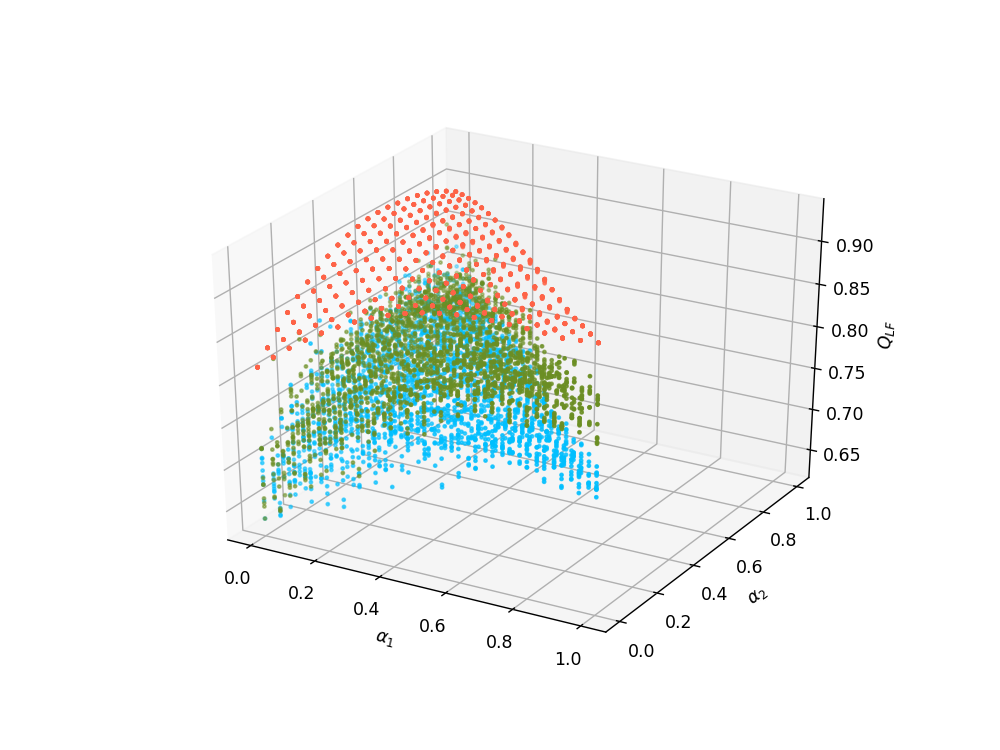

In [35]:
plot_dots(Q_lf, r'$Q_{LF}$', 'data/plots/major_airlines_lf.pdf')

<IPython.core.display.Javascript object>


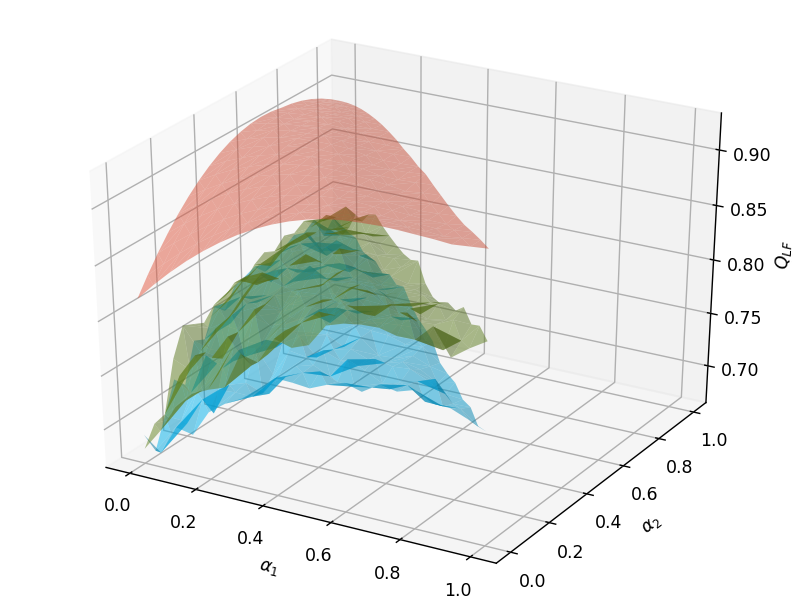

In [36]:
plot_surface(extract_median(Q_lf, simulations_number), r'$Q_{LF}$', 'data/plots/london_surf_lf.pdf')

---------------------

# Delta

In [37]:
delta = {name: None for name in['sf', 'ef', 'lf']}
for name in delta.keys():
    delta[name] = delta_experiment(partition[name], graph_layers_nx, alpha_order)

<IPython.core.display.Javascript object>


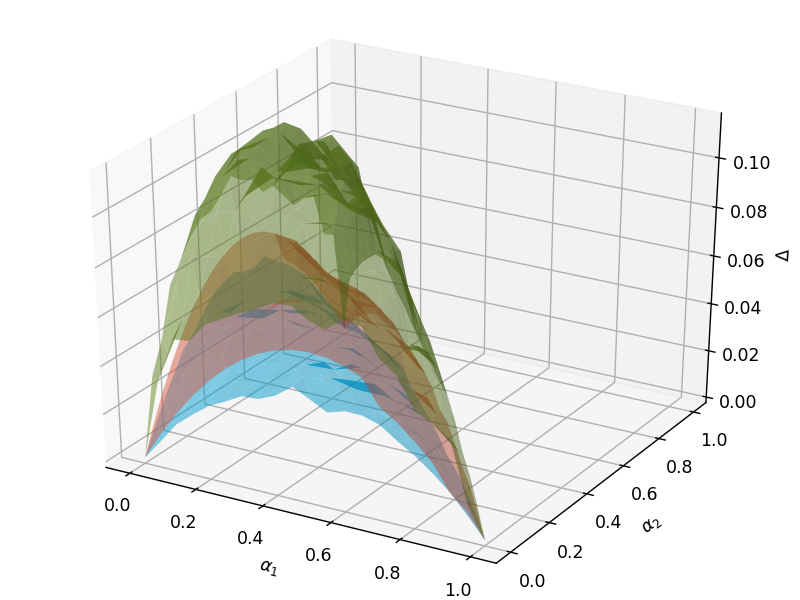

In [38]:
plot_surface(extract_median(delta, simulations_number), '$\Delta$', 'data/plots/london_surf_delta.pdf')

# Theta

In [39]:
theta = {name: None for name in['sf', 'ef', 'lf']}
for name in ['sf', 'ef', 'lf']:
    theta[name] = theta_experiment(partition[name], partition_phase1, graph_layers_nx, alpha_order)

<IPython.core.display.Javascript object>


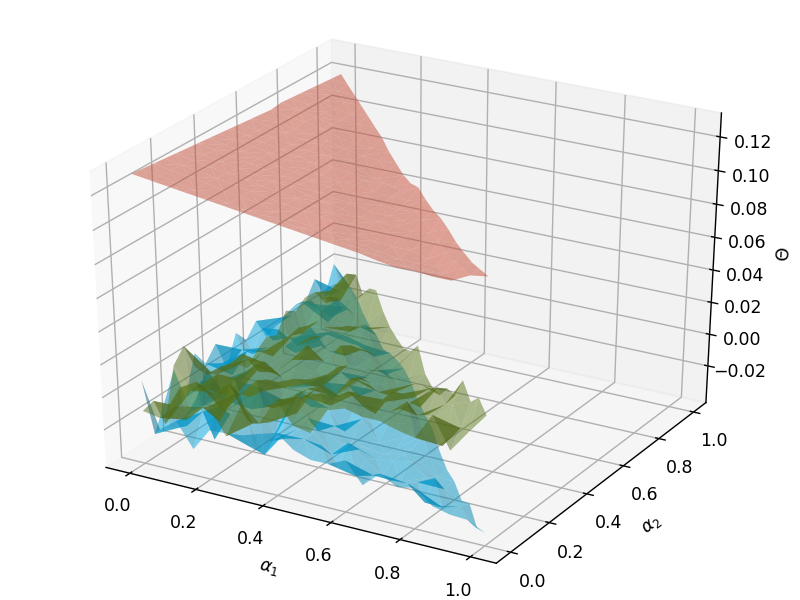

In [40]:
plot_surface(extract_median(theta, simulations_number), '$\Theta$', 'data/plots/london_surf_theta.pdf')

# Delta new

In [41]:
delta_new = {name: None for name in['sf', 'ef', 'lf']}
for name in delta_new.keys():
    delta_new[name] = delta_experiment(partition[name], short_graph_layers_lf, alpha_order)

<IPython.core.display.Javascript object>


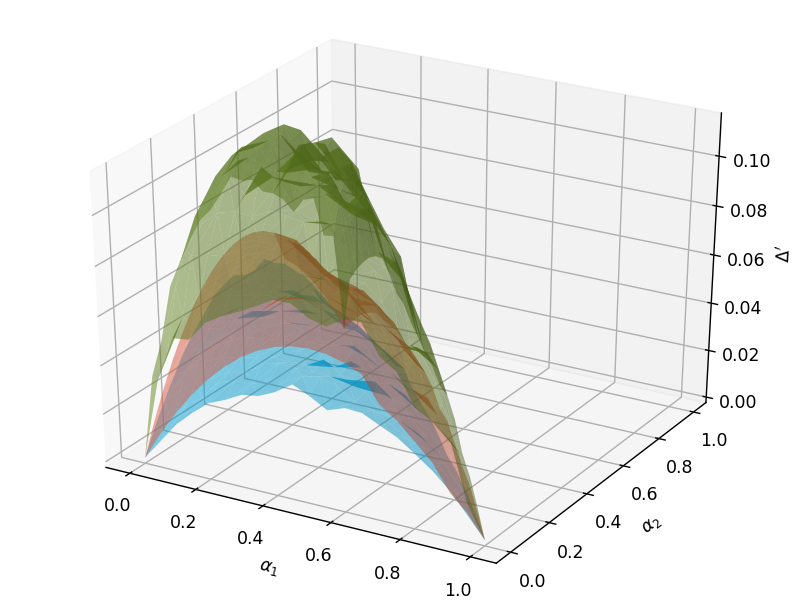

In [42]:
plot_surface(extract_median(delta_new, simulations_number), '$\Delta\'$', 'data/plots/london_surf_delta_new.pdf')

----
## Plot with fixed $\alpha$ (slice)
All Leiden \
$\alpha_1 = 0$:

In [ ]:
data_sf = data_fixed_alpha(Q_sf, alpha_number=1, alpha_value=0)
plot_dots_2d(data_sf, r'$Q_{SF}$', 'data/plots/major_airlines_sf_alpha_fixed.pdf')

In [ ]:
data_ef = data_fixed_alpha(Q_ef, alpha_number=1, alpha_value=0)
plot_dots_2d(data_ef, r'$Q_{EF}$', 'data/plots/major_airlines_ef_alpha_fixed.pdf')

In [ ]:
data_lf = data_fixed_alpha(Q_lf, alpha_number=1, alpha_value=0)
plot_dots_2d(data_lf, r'$Q_{LF}$', 'data/plots/major_airlines_lf_alpha_fixed.pdf')

$\alpha_2=0$:

In [ ]:
data_sf = data_fixed_alpha(Q_sf, alpha_number=2, alpha_value=0)
plot_dots_2d(data_sf, r'$Q_{SF}$', 'data/plots/major_airlines_sf_alpha_2_fixed.pdf')

In [ ]:
data_ef = data_fixed_alpha(Q_ef, alpha_number=2, alpha_value=0)
plot_dots_2d(data_ef, r'$Q_{EF}$', 'data/plots/major_airlines_ef_alpha_2_fixed.pdf')

In [ ]:
data_lf = data_fixed_alpha(Q_lf, alpha_number=2, alpha_value=0)
plot_dots_2d(data_lf, r'$Q_{LF}$', 'data/plots/major_airlines_lf_alpha_2_fixed.pdf')

-----
SF - Leiden, EF and LF - Louvain

$\alpha_1=0$:

In [ ]:
alpha_number = 1
alpha_value = 0
alpha_left = alphas_grid[alphas_grid[:, alpha_number-1] == alpha_value]
alphas_left_2d = np.delete(alpha_left, alpha_number-1, axis=1)

sf_partit = SF_louvain_2layers(graph_layers_nx[1], graph_layers_nx[2], simulations_number, alphas_left_2d)

In [ ]:
ef_partit = EF_louvain(graph_layers_nx, simulations_number, alphas_grid)
lf_partit, partition_phase1 = LF_louvain(graph_layers_nx, simulations_number, alphas_grid)
partition = {'sf': sf_partit, 'ef': ef_partit, 'lf': lf_partit}

Q_sf = {method: compute_experiment('sf', partition[method], graph_layers_nx)
        for method in ['sf', 'ef', 'lf']}

Q_ef = {method: compute_experiment('ef', partition[method], graph_layers_nx)
        for method in ['sf', 'ef', 'lf']}

Q_lf = {method: compute_experiment('lf', partition[method], 
                                   {name: late_fusion_transient_absorption(graph_layers_nx[name], partition_phase1[name])
                                    for name in graph_names}) for method in ['sf', 'ef', 'lf']}

In [ ]:
data_sf = data_fixed_alpha(Q_sf, alpha_number=1, alpha_value=0)
plot_dots_2d(data_sf, r'$Q_{SF}$', 'data/plots/major_airlines_sf_alpha_fixed_mixed.pdf')

In [ ]:
data_ef = data_fixed_alpha(Q_ef, alpha_number=1, alpha_value=0)
plot_dots_2d(data_ef, r'$Q_{EF}$', 'data/plots/major_airlines_ef_alpha_fixed_mixed.pdf')

In [ ]:
data_lf = data_fixed_alpha(Q_lf, alpha_number=1, alpha_value=0)
plot_dots_2d(data_lf, r'$Q_{LF}$', 'data/plots/major_airlines_lf_alpha_fixed_mixed.pdf')

$\alpha_2=0$:

In [ ]:
data_sf = data_fixed_alpha(Q_sf, alpha_number=2, alpha_value=0)
plot_dots_2d(data_sf, r'$Q_{SF}$', 'data/plots/major_airlines_sf_alpha_2_fixed_mixed.pdf')

In [ ]:
data_ef = data_fixed_alpha(Q_ef, alpha_number=2, alpha_value=0)
plot_dots_2d(data_ef, r'$Q_{EF}$', 'data/plots/major_airlines_ef_alpha_2_fixed_mixed.pdf')

In [ ]:
data_lf = data_fixed_alpha(Q_lf, alpha_number=2, alpha_value=0)
plot_dots_2d(data_lf, r'$Q_{LF}$', 'data/plots/major_airlines_lf_alpha_2_fixed_mixed.pdf')

-----
# Ternary plot

In [ ]:
from __future__ import division
method = 'lf'
data= np.concatenate((np.array(Q_sf[method][0]), to_matrix(Q_sf[method][1], 1)), axis=1)

In [ ]:
ternary_plot(data, vmin=0, vmax=0.5)